In [1]:
import awkward as ak
import os
import pickle


import matplotlib.pyplot as plt
import numpy as np
plt.style.use("../science.mplstyle")

from helpers.physics_functions import *

In [2]:
muon_vars = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge", "Muon_tightId", "Muon_pfRelIso03_all", "Muon_pfRelIso04_all", "Muon_jetIdx"]
jet_vars = ["Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass", "Jet_nConstituents", "Jet_btagCSVV2", "Jet_btagDeepB", "Jet_btagDeepFlavB", "MET_pt", "MET_sumEt"]

path_to_input = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/skimmed_data_2016H_30555/"
path_to_output = f"/pscratch/sd/r/rmastand/dimuonAD/compiled_data/lowmass/"

num_files = 28


In [3]:
run_jet = True

all_data = {

      "muon_iso03": [],
     "mu0_eta": [],
     "mu1_eta": [],
    "mu0_pt": [],
     "mu1_pt": [],
    "mu0_phi": [],
     "mu1_phi": [],
      "muon_iso04": [],
      "dimu_pt": [],
      "dimu_eta": [],
     "dimu_phi": [],
     "n_muons": [],
     "n_jets": [],
      "dimu_mass": [],
    }

if run_jet:
    all_data["hardest_jet_btag"] =  []
    all_data["hardest_jet_pt"] =  []
    all_data["hardest_jet_eta"] =  []
    all_data["hardest_jet_phi"] =  []
    all_data["hardest_jet_mass"] =  []

a = list(all_data.keys())

run_samesign = False
if run_samesign:
    for key in a:
        all_data[key+"_samesign"] = []


In [4]:
 for i in range(28):
    
    print(f"Analyzing file {i+1} of {num_files}...")
    
    # LOAD IN DATA
    
    with open(f"{path_to_input}/all_mu_{i}", "rb") as input_file:
        loc_mu_feature = pickle.load(input_file)
        
    with open(f"{path_to_input}/all_jet_{i}", "rb") as input_file:
        loc_jet_feature = pickle.load(input_file)
        
    with open(f"{path_to_input}/all_e_{i}", "rb") as input_file:
        loc_e_feature = pickle.load(input_file)
        
    """
    # ALL MUONS

    muons = ak.zip({
        "pt": loc_mu_feature["Muon_pt"],
        "eta": loc_mu_feature["Muon_eta"],
        "phi": loc_mu_feature["Muon_phi"],
        "charge": loc_mu_feature["Muon_charge"],
        "iso03": loc_mu_feature["Muon_pfRelIso03_all"],
        "iso04": loc_mu_feature["Muon_pfRelIso04_all"],
            })

    muon_pairs = ak.combinations(muons, 2)
    mu1, mu2 = ak.unzip(muon_pairs)
    dimu_mass, dimu_pt, dimu_eta, _ = assemble_m_inv(muon_mass, mu1.pt, mu1.eta, mu1.phi, 
                                   muon_mass, mu2.pt,  mu2.eta,  mu2.phi)
    
    total_charge = mu1.charge + mu2.charge
    total_iso03 = mu1.iso03 + mu2.iso03
    total_iso04 = mu1.iso04 + mu2.iso04
    

    all_data["num_muon_pairs"].append(ak.count(dimu_mass[total_charge==0], axis = 1).to_numpy(allow_missing = True))
    
    all_data["n_muon"].append(ak.count(loc_mu_feature["Muon_charge"][loc_mu_feature["Muon_charge"]==-1], axis = 1).to_numpy(allow_missing = True))
    all_data["n_amuon"].append(ak.count(loc_mu_feature["Muon_charge"][loc_mu_feature["Muon_charge"]==1], axis = 1).to_numpy(allow_missing = True))
    all_data["dimu_mass_0"].append(ak.firsts(dimu_mass[total_charge==0]).to_numpy(allow_missing = True))
    
    loc_filter = ak.count(dimu_mass[total_charge==0], axis = 1) > 1
    all_data["dimu_mass_1"].append(dimu_mass[total_charge==0][loc_filter][:,1].to_numpy(allow_missing = True))
    
    loc_filter = ak.count(dimu_mass[total_charge==0], axis = 1) > 2
    all_data["dimu_mass_2"].append(dimu_mass[total_charge==0][loc_filter][:,2].to_numpy(allow_missing = True))
    """
    
    # 2 hard muons that pass tight ID
    # DROPPED jet requirement
    if run_jet:
        event_filter = (np.sum(loc_mu_feature["Muon_tightId"], axis = 1) >= 2) & ak.count(loc_jet_feature["Jet_pt"], axis = 1) >= 1
    else:
        event_filter = (np.sum(loc_mu_feature["Muon_tightId"], axis = 1) >= 2) 
   
    def pull_tight_muons(feature):
        return loc_mu_feature[feature][loc_mu_feature["Muon_tightId"]][event_filter]
    
    

    dimu_mass, dimu_pt, dimu_eta, dimu_phi = assemble_m_inv(muon_mass, pull_tight_muons("Muon_pt")[:,0], pull_tight_muons("Muon_eta")[:,0], pull_tight_muons("Muon_phi")[:,0], 
                                   muon_mass, pull_tight_muons("Muon_pt")[:,1],  pull_tight_muons("Muon_eta")[:,1],  pull_tight_muons("Muon_phi")[:,1])
    
    total_charge = pull_tight_muons("Muon_charge")[:,0] + pull_tight_muons("Muon_charge")[:,1]
    total_iso03 = pull_tight_muons("Muon_pfRelIso03_all")[:,0] + pull_tight_muons("Muon_pfRelIso03_all")[:,1]
    total_iso04 = pull_tight_muons("Muon_pfRelIso04_all")[:,0] + pull_tight_muons("Muon_pfRelIso04_all")[:,1]
    
    # filters for opp-sign and same-sign muons; must apply *after* the event filter
    samesign_filter = np.abs(total_charge) == 2
    oppsign_filter = np.abs(total_charge) == 0

    # variables that have already had the event filter applied
    all_data["dimu_mass"].append(dimu_mass[oppsign_filter].to_numpy(allow_missing = True))
    all_data["dimu_pt"].append(dimu_pt[oppsign_filter].to_numpy(allow_missing = True))
    all_data["dimu_eta"].append(dimu_eta[oppsign_filter].to_numpy(allow_missing = True))
    all_data["dimu_phi"].append(dimu_phi[oppsign_filter].to_numpy(allow_missing = True))
    
    all_data["muon_iso03"].append(total_iso03[oppsign_filter].to_numpy(allow_missing = True))
    all_data["muon_iso04"].append(total_iso04[oppsign_filter].to_numpy(allow_missing = True))
    
    
    
    if run_samesign:
 
        all_data["dimu_mass_samesign"].append(dimu_mass[samesign_filter].to_numpy(allow_missing = True))
        all_data["dimu_pt_samesign"].append(dimu_pt[samesign_filter].to_numpy(allow_missing = True))
        all_data["dimu_eta_samesign"].append(dimu_eta[samesign_filter].to_numpy(allow_missing = True))
        all_data["dimu_phi_samesign"].append(dimu_phi[samesign_filter].to_numpy(allow_missing = True))
  
        all_data["muon_iso03_samesign"].append(total_iso03[samesign_filter].to_numpy(allow_missing = True))
        all_data["muon_iso04_samesign"].append(total_iso04[samesign_filter].to_numpy(allow_missing = True))
    
    # variables that need the event filter
    all_data["n_jets"].append(ak.count(loc_jet_feature["Jet_mass"][event_filter], axis = 1)[oppsign_filter].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["n_jets_samesign"].append(ak.count(loc_jet_feature["Jet_mass"][event_filter], axis = 1)[samesign_filter].to_numpy(allow_missing = True))
    
    all_data["n_muons"].append(ak.count(pull_tight_muons("Muon_charge"), axis = 1)[oppsign_filter].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["n_muons_samesign"].append(ak.count(pull_tight_muons("Muon_charge"), axis = 1)[samesign_filter].to_numpy(allow_missing = True))
    
  
    """
    JET VARS
    """
    if run_jet:
        all_data["hardest_jet_btag"].append(ak.firsts(loc_jet_feature["Jet_btagDeepB"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_btag_samesign"].append(ak.firsts(loc_jet_feature["Jet_btagDeepB"][event_filter])[samesign_filter].to_numpy(allow_missing = True))

        all_data["hardest_jet_pt"].append(ak.firsts(loc_jet_feature["Jet_pt"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_pt_samesign"].append(ak.firsts(loc_jet_feature["Jet_pt"][event_filter])[samesign_filter].to_numpy(allow_missing = True))

        all_data["hardest_jet_eta"].append(ak.firsts(loc_jet_feature["Jet_eta"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_eta_samesign"].append(ak.firsts(loc_jet_feature["Jet_eta"][event_filter])[samesign_filter].to_numpy(allow_missing = True))

        all_data["hardest_jet_phi"].append(ak.firsts(loc_jet_feature["Jet_phi"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_phi_samesign"].append(ak.firsts(loc_jet_feature["Jet_phi"][event_filter])[samesign_filter].to_numpy(allow_missing = True))
            
        all_data["hardest_jet_mass"].append(ak.firsts(loc_jet_feature["Jet_mass"][event_filter])[oppsign_filter].to_numpy(allow_missing = True))
        if run_samesign:
            all_data["hardest_jet_mass_samesign"].append(ak.firsts(loc_jet_feature["Jet_mass"][event_filter])[samesign_filter].to_numpy(allow_missing = True))


    all_data["mu0_eta"].append(pull_tight_muons("Muon_eta")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu0_eta_samesign"].append(pull_tight_muons("Muon_eta")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_eta"].append(pull_tight_muons("Muon_eta")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu1_eta_samesign"].append(pull_tight_muons("Muon_eta")[samesign_filter][:,1].to_numpy(allow_missing = True))

    all_data["mu0_pt"].append(pull_tight_muons("Muon_pt")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu0_pt_samesign"].append(pull_tight_muons("Muon_pt")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_pt"].append(pull_tight_muons("Muon_pt")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu1_pt_samesign"].append(pull_tight_muons("Muon_pt")[samesign_filter][:,1].to_numpy(allow_missing = True))

    
    all_data["mu0_phi"].append(pull_tight_muons("Muon_phi")[oppsign_filter][:,0].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu0_phi_samesign"].append(pull_tight_muons("Muon_phi")[samesign_filter][:,0].to_numpy(allow_missing = True))
    all_data["mu1_phi"].append(pull_tight_muons("Muon_phi")[oppsign_filter][:,1].to_numpy(allow_missing = True))
    if run_samesign:
        all_data["mu1_phi_samesign"].append(pull_tight_muons("Muon_phi")[samesign_filter][:,1].to_numpy(allow_missing = True))


 
print("Done!")
    
    

Analyzing file 1 of 28...


/global/homes/r/rmastand/.conda/envs/cernroot/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


Analyzing file 2 of 28...
Analyzing file 3 of 28...
Analyzing file 4 of 28...
Analyzing file 5 of 28...
Analyzing file 6 of 28...
Analyzing file 7 of 28...
Analyzing file 8 of 28...
Analyzing file 9 of 28...
Analyzing file 10 of 28...
Analyzing file 11 of 28...
Analyzing file 12 of 28...
Analyzing file 13 of 28...
Analyzing file 14 of 28...
Analyzing file 15 of 28...
Analyzing file 16 of 28...
Analyzing file 17 of 28...
Analyzing file 18 of 28...
Analyzing file 19 of 28...
Analyzing file 20 of 28...


/global/homes/r/rmastand/.conda/envs/cernroot/lib/python3.11/site-packages/awkward/_nplikes/array_module.py:245: RuntimeWarning: divide by zero encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


Analyzing file 21 of 28...
Analyzing file 22 of 28...
Analyzing file 23 of 28...
Analyzing file 24 of 28...
Analyzing file 25 of 28...
Analyzing file 26 of 28...
Analyzing file 27 of 28...
Analyzing file 28 of 28...
Done!


In [5]:
for key in all_data.keys():
    
    all_data[key] = np.hstack(all_data[key])
    print(key, all_data[key].shape)

    
    
    

muon_iso03 (10640941,)
mu0_eta (10640941,)
mu1_eta (10640941,)
mu0_pt (10640941,)
mu1_pt (10640941,)
mu0_phi (10640941,)
mu1_phi (10640941,)
muon_iso04 (10640941,)
dimu_pt (10640941,)
dimu_eta (10640941,)
dimu_phi (10640941,)
n_muons (10640941,)
n_jets (10640941,)
dimu_mass (10640941,)
hardest_jet_btag (10640941,)
hardest_jet_pt (10640941,)
hardest_jet_eta (10640941,)
hardest_jet_phi (10640941,)
hardest_jet_mass (10640941,)


KeyError: 'dimu_mass_samesign'

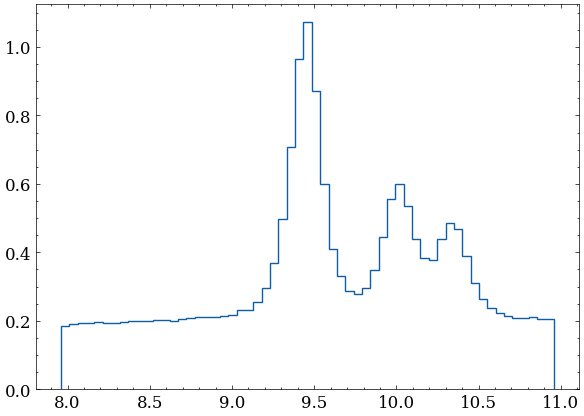

In [6]:
target_M = 9.46 # GeV
delta = 1.5 # GeV


plt.figure()

plt.hist(all_data["dimu_mass"], bins = np.linspace(target_M - delta, target_M + delta, 60), histtype = "step", label = "+-", density = True)
plt.hist(all_data["dimu_mass_samesign"], bins = np.linspace(target_M - delta, target_M + delta, 60), histtype = "step", label = "++,--", density = True)

plt.axvline(target_M, color = "r")

plt.legend()
plt.ylabel("Counts")
plt.xlabel("dimu $M$ [GeV]")
plt.show()

## Calculate supplementary observables

In [7]:
all_data["mumu_deltaR"] = calculate_deltaR(all_data["mu0_phi"], all_data["mu1_phi"], all_data["mu0_eta"], all_data["mu1_eta"])
all_data["mumu_deltapT"] = all_data["mu0_pt"] - all_data["mu1_pt"]

if run_jet:
    all_data["dimujet_deltaR"] = calculate_deltaR(all_data["dimu_phi"], all_data["hardest_jet_phi"], all_data["dimu_eta"], all_data["hardest_jet_eta"])


if run_samesign:
    all_data["mumu_deltaR_samesign"] = calculate_deltaR(all_data["mu0_phi_samesign"], all_data["mu1_phi_samesign"], all_data["mu0_eta_samesign"], all_data["mu1_eta_samesign"])
    all_data["mumu_deltapT_samesign"] = all_data["mu0_pt_samesign"] - all_data["mu1_pt_samesign"]
    
    if run_jet:
        all_data["dimujet_deltaR_samesign"] = calculate_deltaR(all_data["dimu_phi_samesign"], all_data["hardest_jet_phi_samesign"], all_data["dimu_eta_samesign"], all_data["hardest_jet_eta_samesign"])


Make cuts on deltsaR min

In [ ]:
nb = 40
mass_low, mass_high = target_M - delta, target_M + delta

keys_to_plot =  ["mu0_eta", "mu1_eta", "dimu_eta", "mumu_deltaR", "mumu_deltapT", "dimu_mass"]
labels = ["hardest mu $\eta$","second mu $\eta$", "dimu $\eta$", "$\mu-\mu$ $\Delta R$", "$\mu-\mu$ $\Delta p_T$", "dimu $M$"]
bins = [np.linspace(-2.5, 2.5, nb), np.linspace(-2.5, 2.5, nb),np.linspace(-2.5, 2.5, nb), np.linspace(0, .25, nb),np.linspace(0, 50, nb), np.linspace(mass_low, mass_high, nb)]
n_features = len(keys_to_plot)




eta_min, eta_max = -8, 8
event_filter_opp =  (all_data["mumu_deltaR"] > 0.0)  & (all_data["dimu_mass"] > mass_low)  & (all_data["dimu_mass"] < mass_high) & (all_data["mu0_eta"] < eta_max) & (all_data["mu0_eta"] > eta_min)
event_filter_ss =  (all_data["mumu_deltaR_samesign"] > 0.00)  & (all_data["dimu_mass_samesign"] > mass_low)  & (all_data["dimu_mass_samesign"] < mass_high) & (all_data["mu0_eta_samesign"] < eta_max) & (all_data["mu0_eta_samesign"] > eta_min)


colors = ["purple", "blue", "green", "orange", "red", "magenta"]

fig, ax = plt.subplots(1, n_features, figsize = (3*n_features, 3))

for i, key in enumerate(keys_to_plot):
    
    for j, delta_R_min in enumerate([0., 0.005, 0.01, 0.015, 0.02, 0.025]):
    
        event_filter_opp =  (all_data["mumu_deltaR"] >delta_R_min)  & (all_data["dimu_mass"] > mass_low)  & (all_data["dimu_mass"] < mass_high) & (all_data["mu0_eta"] < eta_max) & (all_data["mu0_eta"] > eta_min)
        event_filter_ss =  (all_data["mumu_deltaR_samesign"] > delta_R_min)  & (all_data["dimu_mass_samesign"] > mass_low)  & (all_data["dimu_mass_samesign"] < mass_high) & (all_data["mu0_eta_samesign"] < eta_max) & (all_data["mu0_eta_samesign"] > eta_min)

        if delta_R_min == 0:
            label0 = "opp. sign"
            label1 = "same sign"
        else:
            label0 = None
            label1 = None

        #ax[i].hist(all_data[key][event_filter_opp], bins= bins[i], histtype = "step", label = label0, density = True, color = colors[j])
        ax[i].hist(all_data[key+"_samesign"][event_filter_ss], bins= bins[i], histtype = "step", lw = 2, label = "deltaR > " + str(delta_R_min), density = False, color = colors[j])


 
    ax[i].set_xlabel(labels[i])
    ax[i].set_yticks([])
    
ax[3].legend(fontsize = 10)
ax[0].set_ylabel("Counts")

plt.subplots_adjust(wspace=0)
plt.show()




In [ ]:
nb = 40

keys_to_plot =  ["muon_iso03", "muon_iso04","mu0_pt", "mu1_pt",  
                 "mu0_eta", "mu1_eta", "dimu_pt", "dimu_eta",
                 "jet_pt", "jet_eta", "n_jets", 
                 "dimujet_deltaR", "jet_btag",  "mumu_deltaR", "mumu_deltapT", "dimu_mass"]

labels = ["(mu+amu) isoR03", "(mu+amu) isoR04", "hardest mu $p_T$","second mu $p_T$",
          "hardest mu $\eta$","second mu $\eta$", "dimu $p_T$ [GeV]", "dimu $\eta$",
          "Hardest jet $p_T$ [GeV]",   "Hardest j $\eta$",     "num. jets",
          "$\mu\mu$-jet $\Delta R$",   "Hardest jet btag",    "$\mu-\mu$ $\Delta R$","$\mu-\mu$ $\Delta$ $p_T$", "dimu $M$ [GeV]"]

n_features = len(keys_to_plot)

mass_low, mass_high = 9.2, 9.7

bins = [np.linspace(0, 4, nb),np.linspace(0, 4, nb), np.linspace(0, 75, nb),np.linspace(0, 50, nb),
        np.linspace(-3, 3, nb), np.linspace(-3, 3, nb),   np.linspace(0, 150, nb),np.linspace(-3, 3, nb),
        np.linspace(0, 300, nb),  np.linspace(-3, 3, nb), np.arange(-0.5, 10.5, 1),
        np.linspace(0, 1, nb), np.linspace(0, 1, nb), np.linspace(0, 1, nb), np.linspace(0, 50, nb), np.linspace(8, 11, nb)]

event_filter_opp = (all_data["dimu_mass"] > mass_low)  & (all_data["dimu_mass"] < mass_high)
event_filter_ss = (all_data["dimu_mass_samesign"] > mass_low)  & (all_data["dimu_mass_samesign"] < mass_high)
event_filter_outrange = ((all_data["dimu_mass"] < (mass_low))  | (all_data["dimu_mass"] > (mass_high)) ) & ( (all_data["dimu_mass"] < 9.8))& ( (all_data["dimu_mass"] > 8))


fig, ax = plt.subplots(4, 4, figsize = (12, 12))

for i, key in enumerate(keys_to_plot):


    ax.flat[i].hist(all_data[key][event_filter_opp], bins= bins[i], histtype = "step", label = "+-", density = True, color = "blue")
    #ax.flat[i].hist(all_data[key+"_samesign"][event_filter_ss], bins= bins[i], histtype = "step", label = "++,--", density = True, color = "orange")
    ax.flat[i].hist(all_data[key][event_filter_outrange], bins= bins[i], histtype = "step", label = "exterior +-", density = True, color = "green")
    
    
    ax.flat[i].legend(fontsize = 12)
    
    ax.flat[i].set_xlabel(labels[i], fontsize = 12)
    ax.flat[i].set_yticks([])
    
#ax.flat[0].legend(fontsize = 12)
ax.flat[0].set_ylabel("Density")

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()

In [8]:
with open(f"{path_to_output}/DATA_jet", "wb") as output_file:
        pickle.dump(all_data, output_file)

In [ ]:
muon_iso_cuts = np.arange(0.5, 2, 0.15) # anti-isolation cut -- want muon iso to be ABOVE this, which means more junk
dimuon_pt_cuts = [20, 30, 40, 50, 60, 70]

isoc = 2
ptc = 0


plt.figure(figsize = (7,5))
    
#for isoc in muon_iso_cuts:
for ptc in dimuon_pt_cuts:
    
    
    loc_filter = (all_data["muon_iso03"]>=isoc)  &(all_data["dimu_pt"]>=ptc) 
    plt.hist(all_data["dimu_mass"][loc_filter], bins = np.arange(9, 10, 0.01), 
            histtype = "step", 
           # label = f"mu+amu iso R04 > {round(isoc, 2)}"
             label = f"dimu pT > {round(ptc, 2)} GeV"
            )

plt.title(f"mu+amu iso R04 > {round(isoc, 2)}")

plt.axvline(9.46)

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))
plt.show()
